In [1]:
from models import binary_classifier
from data_loader_util import load_dataset_from_h5,evaluate_dir
from image_utils import display_image,load_image
from early_stopping_util import EarlyStoppingCallback
from model_util import evaluate,save_model,load_model,predict
from reporting_utils import batch_predict,predict_single,predict_images_from_test_set
import pandas as pd 
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2


In [2]:
train_data_set = './datasets/train_catvnoncat.h5'
test_data_set = './datasets/test_catvnoncat.h5'

# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset_from_h5(train_data_set,test_data_set)

In [3]:
# Standardize data to have feature values between 0 and 1.
train_x = train_set_x_orig / 255.
test_x = test_set_x_orig / 255.

train_y = train_set_y.T
test_y = test_set_y.T

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))
print ("train_y's shape: " + str(train_set_y.shape))

train_x's shape: (209, 64, 64, 3)
test_x's shape: (50, 64, 64, 3)
train_y's shape: (1, 209)


In [12]:
model = binary_classifier(
    optimizer='adam',
    loss='binary_crossentropy')
    
history = model.fit(
        train_x,
        train_y,
        validation_data=(test_x, test_y),
        epochs=50,
        callbacks=[EarlyStoppingCallback()],
    )

Epoch 1/50
7/7 [==============================] - 4s 420ms/step - loss: 0.7920 - accuracy: 0.5311 - val_loss: 0.7445 - val_accuracy: 0.3400
0.5645933151245117
Epoch 2/50
7/7 [==============================] - 1s 117ms/step - loss: 0.5783 - accuracy: 0.6720 - val_loss: 1.1430 - val_accuracy: 0.3400
0.6842105388641357
Epoch 3/50
7/7 [==============================] - 1s 127ms/step - loss: 0.5769 - accuracy: 0.6888 - val_loss: 0.6608 - val_accuracy: 0.5400
0.7224880456924438
Epoch 4/50
7/7 [==============================] - 1s 139ms/step - loss: 0.4581 - accuracy: 0.7414 - val_loss: 0.4609 - val_accuracy: 0.7800
0.7320573925971985
Epoch 5/50
7/7 [==============================] - 1s 127ms/step - loss: 0.4357 - accuracy: 0.8134 - val_loss: 0.6180 - val_accuracy: 0.6000
0.8229665160179138
Epoch 6/50
7/7 [==============================] - 1s 147ms/step - loss: 0.3693 - accuracy: 0.8424 - val_loss: 0.6095 - val_accuracy: 0.6400
0.8468899726867676
Epoch 7/50
7/7 [==============================

In [13]:
result = evaluate(model, test_x, test_y)
print('\nTest accuracy:', result[1])

2/2 - 0s - loss: 0.8043 - accuracy: 0.7400

Test accuracy: 0.7400000095367432


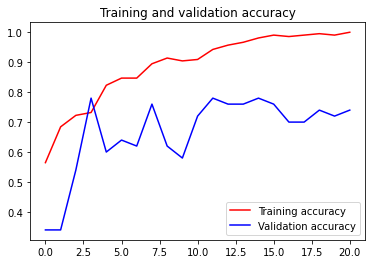

<Figure size 432x288 with 0 Axes>

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [6]:
save_model(model,'./models/binary_image_classifier')

INFO:tensorflow:Assets written to: ./models/binary_image_classifier/assets


In [7]:
correct_predictions = pd.DataFrame({ 'predictions': [1,0,0,0,1,0]  })
class_names = ['cat ', 'Not cat']
model = load_model('./models/binary_image_classifier')
image_shape = (64,64,3)

'cat '

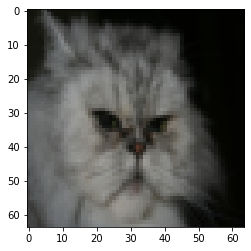

In [8]:
predict_images_from_test_set(model,test_x,class_names,12)

In [9]:
path = '/Users/prashunjaveri/Desktop/eval'
batch_predict(path=path,
            model=model,
            shape=image_shape,
            classes=class_names,
            correct_predictions=correct_predictions,
            show_all = False ,
            show_correct = False)

{'errors': [{'file': 'download.jpeg',
   'predictions': 0,
   'predicted_labels': 'cat ',
   'expected': 1,
   'expected_labels': 'Not cat'},
  {'file': 'not_cat.png',
   'predictions': 0,
   'predicted_labels': 'cat ',
   'expected': 1,
   'expected_labels': 'Not cat'}],
 'percentage_error': 33.33333333333334}

'cat '

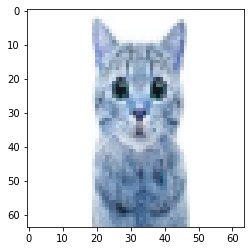

In [10]:
path = '/Users/prashunjaveri/Desktop/cat.jpeg'
predict_single(path=path,
            model=model,
            shape=image_shape,
            classes=class_names,
            show_image = True )